# 2021-03-01 国盛证券-多因子系列之十五：分析师盈利修正后的股价漂移（PFRD） 

In [1]:
import dcube as dc
import pandas as pd
import datetime
from datetime import timedelta
from tqdm import tqdm
import numpy as np
from fastcache import lru_cache
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

df_preclose=pd.read_csv(r'C:\Users\nibh\Desktop\FZ\daily_factor\EODP__S_DQ_ADJPRECLOSE.csv',index_col=0)
df_preclose.index = pd.to_datetime(df_preclose.index).date
df_csi=pd.read_csv(r'C:\Users\nibh\Desktop\FZ\daily_factor\指数收盘价.csv',index_col=0)
df_csi=df_csi.drop('HS300',axis=1)
df_csi.index = pd.to_datetime(df_csi.index).date

token = ''
pro = dc.pro_api(token)

## 一、数据获取

In [1]:
# （一）盈利预测数据的获取
df1 = pro.query('ashare_earning_est',start_date='20170101', end_date='20181231', fields='s_info_windcode,est_dt,research_inst_name,est_dt,est_net_profit,reporting_period')
df2 = pro.query('ashare_earning_est',start_date='20190101', end_date='20201231', fields='s_info_windcode,est_dt,research_inst_name,est_dt,est_net_profit,reporting_period')
df3 = pro.query('ashare_earning_est',start_date='20210101', end_date='20211231', fields='s_info_windcode,est_dt,research_inst_name,est_dt,est_net_profit,reporting_period')
df4 = pro.query('ashare_earning_est',start_date='20220101', end_date='20221231', fields='s_info_windcode,est_dt,research_inst_name,est_dt,est_net_profit,reporting_period')

df=pd.concat([df1,df2,df3,df4]).sort_values(by=['s_info_windcode','research_inst_name','reporting_period','est_dt'])
df=df.sort_values(by=['s_info_windcode','research_inst_name','reporting_period','est_dt'])
df['reporting_period'] = pd.to_datetime(df['reporting_period']).dt.date

df5 = df.dropna()
df5 = df5[df5['est_net_profit'] != 0]
df5 = df5[df5['reporting_period'].apply(lambda x:x.year) == df5['est_dt'].apply(lambda x:x.year)] #针对当年预测

# 按照's_info_windcode'和'research_inst_name'进行分组，删除单期报告仅一个预测值的样本
grouped1 = df5.groupby(['s_info_windcode', 'research_inst_name','reporting_period']).filter(lambda x:len(x)>1)
grouped1.reset_index(drop=True,inplace=True)

In [277]:
# （二）一致预测数据的获取
start_date = datetime.date(2017,1,1)
end_date = datetime.date(2023,8,31)
date_list = []

# 数据量太大，为避免达到提取上限，按月提取
while start_date <= end_date:
    year = start_date.year
    month = start_date.month
    last_day_of_month = start_date.replace(day=28)+timedelta(days=4)
    end_of_month = last_day_of_month-timedelta(days=last_day_of_month.day)
    date_list.append((start_date.strftime('%Y%m%d'),end_of_month.strftime('%Y%m%d')))
    start_date = end_of_month+timedelta(days=1)

cons_list=[]
for start_date,end_date in tqdm(date_list):
    df_cons = pro.query('a_share_consensusrollingdata',start_date=start_date,end_date=end_date,rolling_type='FY1',fields='code,trade_date,net_profit')
    cons_list.append(df_cons)

df_consensus = pd.concat(cons_list).sort_values(by=['code','trade_date'])
df_consensus

,code,trade_date,net_profit
59547,000001.SZ,2017-01-01,2.347689e+10
52237,000001.SZ,2017-01-02,2.347689e+10
52261,000001.SZ,2017-01-03,2.347689e+10
52262,000001.SZ,2017-01-04,2.347689e+10
52000,000001.SZ,2017-01-05,2.347689e+10
52001,000001.SZ,2017-01-06,2.347689e+10
52025,000001.SZ,2017-01-07,2.347689e+10
52026,000001.SZ,2017-01-08,2.347689e+10
52027,000001.SZ,2017-01-09,2.347689e+10
52028,000001.SZ,2017-01-10,2.347689e+10


## 二、计算各变量

In [129]:
# 获取所有的交易日期
@lru_cache(1)
def get_all_trade_days(start_date='20110101'):
    df = pro.trade_cal(exchange='', start_date=pd.to_datetime(start_date).strftime('%Y%m%d'),is_open='1')
    trade_days = df['cal_date'].tolist()
    all_days = pd.to_datetime(trade_days)
    all_days = [date.date() for date in all_days]
    return all_days

# 获取指定日期的前后交易日
@lru_cache(1)
def get_near_trade_day(date):
    trade_days = get_all_trade_days()
    date = pd.to_datetime(date).date()
    
    # 获取t+0交易日
    while date not in trade_days:
        date = (date + timedelta(days=1))
    index = trade_days.index(date)
    
    date_minus1 = trade_days[index-1]        # 获取t-1交易日  
    date_t1 = trade_days[index+1]            # 获取t+1交易日 
    date_t120 =trade_days[index+120]         # 获取t+120交易日   
    return date,date_minus1,date_t1,date_t120

# 1.分组计算：同一机构对同一报告期内同一股票的两次盈利预测修正的时间差
grouped2 = grouped1.copy()
grouped2['est_dt'] = pd.to_datetime(grouped2['est_dt']).dt.date
grouped2['time_diff'] = grouped2.groupby(['s_info_windcode','research_inst_name','reporting_period'])['est_dt'].diff(periods=1).dt.days
grouped2['est_date_interval'] = pd.cut(grouped2['time_diff'], bins=[-np.inf, 30, 90, np.inf], labels=[1, 2, 3])

# 2.分组计算：盈利预测修正大小
grouped2['rev_growth'] = grouped2.groupby(['s_info_windcode','research_inst_name','reporting_period'])['est_net_profit'].pct_change()

# 3.rev_ret和CAR的计算
grouped3 = grouped2.copy()
for i,(stock,date) in tqdm(enumerate(zip(grouped3['s_info_windcode'],grouped3['est_dt'])),total=len(grouped3)):
    if stock in df_preclose.columns:
        t0,t_1,t1,t120 = get_near_trade_day(date)
        rev_ret_pcl = (df_preclose.loc[t0,stock] - df_preclose.loc[t_1,stock]) / df_preclose.loc[t_1,stock]
        rev_ret_base = (df_csi.loc[t0] - df_csi.loc[t_1]) / df_csi.loc[t_1]
        grouped3.loc[i,'rev_ret'] = float(rev_ret_pcl - rev_ret_base)
        if t120 <= np.minimum(df_preclose.index.max(),df_csi.index.max()):
            ret_stock = (df_preclose.loc[t120,stock] - df_preclose.loc[t1,stock]) / df_preclose.loc[t1,stock]
            ret_base = (df_csi.loc[t120] - df_csi.loc[t1]) / df_csi.loc[t1]
            grouped3.loc[i,'CAR'] = float(ret_stock - ret_base)

# 匹配grouped4和df_consensus
df_consensus['trade_date'] = pd.to_datetime(df_consensus['trade_date']).dt.date
grouped4 = pd.merge(grouped3,df_consensus,left_on=['s_info_windcode','est_dt'],right_on=['code','trade_date'],how='left')
grouped4.drop(columns=['code', 'trade_date'], inplace=True)

# 4.rev_to_cons, cons_rev, innovation, innovation1的计算
grouped5 = grouped4.copy()
grouped5['rev_to_cons'] = (grouped5['est_net_profit'] - grouped5['net_profit'].shift(1)) / grouped5['net_profit'].shift(1)
grouped5['cons_rev'] = grouped5.groupby(['s_info_windcode','research_inst_name','reporting_period'])['net_profit'].pct_change()
grouped5['innovation1'] = np.where(((np.sign(grouped5['rev_growth'])==1) & (np.sign(grouped5['cons_rev'])==1)),1,
                                   np.where(((np.sign(grouped5['rev_growth'])== -1) & (np.sign(grouped5['cons_rev'])== -1)),-1,0))
grouped5['pre_est_net_profit'] = grouped5['est_net_profit'].shift(1)
grouped5['pre_net_profit'] = grouped5['net_profit'].shift(1)
series_bool_min = (grouped5['est_net_profit']>=np.minimum(grouped5['pre_net_profit'],grouped5['pre_est_net_profit']))
series_bool_max = (grouped5['est_net_profit']<=np.maximum(grouped5['pre_net_profit'],grouped5['pre_est_net_profit']))
grouped5['bool_min']=series_bool_min
grouped5['bool_max']=series_bool_max
grouped5['innovation'] = np.where(series_bool_min & series_bool_max,0,np.where(series_bool_min,1,-1))


### 数据处理

(212138, 19)
(207545, 19)
盈利修正为0的样本量：92128


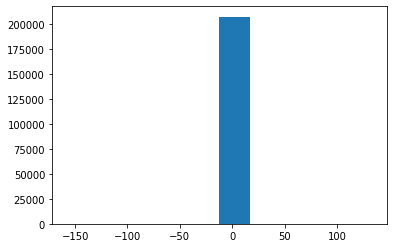

In [131]:
# 1.删除两次预测超过180天的样本，以及盈利预测修正为0的样本
grouped6 = grouped5.dropna()
print(grouped6.shape)
grouped6 = grouped6[grouped6['time_diff']<=180]
print(grouped6.shape)
print('盈利修正为0的样本量：' + str(sum(grouped6['rev_growth'] == 0)))
plt.hist(grouped6['rev_growth'])
grouped6 = grouped6[grouped6['rev_growth']!=0]

(array([  585.,   459.,  1330.,  5820., 49111., 50344.,  4897.,  1313.,
          573.,   985.]),
 array([-1.12387500e+00, -8.99304571e-01, -6.74734137e-01, -4.50163703e-01,
        -2.25593270e-01, -1.02283587e-03,  2.23547598e-01,  4.48118032e-01,
         6.72688465e-01,  8.97258899e-01,  1.12182933e+00]),
 <BarContainer object of 10 artists>)

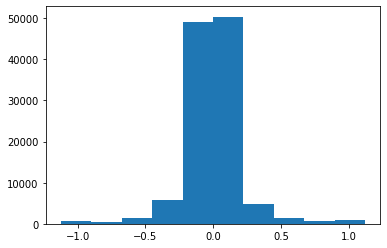

In [132]:
# 2.缩尾
iqr = grouped6['rev_growth'].quantile(0.95) - grouped6['rev_growth'].quantile(0.05)
low_bench = grouped6['rev_growth'].quantile(0.05) - 1.5*iqr
high_bench = grouped6['rev_growth'].quantile(0.95) + 1.5*iqr
grouped6['rev_growth'] = np.clip(grouped6['rev_growth'],low_bench,high_bench)
grouped7 = grouped6[['s_info_windcode','est_dt','CAR','rev_growth','rev_ret','rev_to_cons','innovation','innovation1','cons_rev','est_date_interval']]
plt.hist(grouped7['rev_growth'])

## 三、构建因子

In [138]:
# （一）划分数据集
# 划分数据集为样本内和样本外
def split_dataset(df,current_date,list_X,Y,list_ID):
    sample_in_start=datetime.date(current_date.year-2,current_date.month,current_date.day)
    sample_in_end=current_date-datetime.timedelta(days=1)
    sample_out_start=current_date
    sample_out_end=datetime.date(current_date.year+1,current_date.month,current_date.day)
    
    sample_in_data=df[(df['est_dt']>=sample_in_start) & (df['est_dt']<=sample_in_end)]
    sample_in_data=sample_in_data.reset_index(drop=True,inplace=True)
    sample_in_X=sample_in_data[list_X]
    sample_in_Y=sample_in_data[Y]
    sample_out_data=df[(df['est_dt']>=sample_out_start) & (df['est_dt']<sample_out_end)]
    sample_out_data=sample_out_data.reset_index(drop=True,inplace=True)
    sample_out_X=sample_out_data[list_X]
    sample_out_Y=sample_out_data[Y]
    ID_out=sample_out_data[list_ID]
    
    return sample_in_X,sample_in_Y,sample_out_X,sample_out_Y,ID_out

# 根据滚动窗口划分数据集
def generate_rolling_datasets(df,start_date,end_date,list_X,Y,list_ID):
    X_in_all=[]
    Y_in_all=[]
    X_out_all=[]
    Y_out_all=[]
    ID_out_all=[]
    while start_date<=end_date:
        sample_in_X,sample_in_Y,sample_out_X,sample_out_Y,ID_out=split_dataset(df,start_date,list_X,Y,list_ID)
        X_in_all.append(sample_in_X)
        Y_in_all.append(sample_in_Y)
        X_out_all.append(sample_out_X)
        Y_out_all.append(sample_out_Y)
        ID_out_all.append(ID_out)
        start_date=datetime.date(start_date.year+1,start_date.month,start_date.day)
    return X_in_all,Y_in_all,X_out_all,Y_out_all,ID_out_all

# 生成滚动划分的数据集
grouped7['est_dt'] = pd.to_datetime(grouped7['est_dt']).dt.date
X_in_all,Y_in_all,X_out_all,Y_out_all,ID_out_all=generate_rolling_datasets(grouped7,datetime.date(2019,1,1),datetime.date(2022,1,1),
                list_X=['rev_growth','rev_ret','rev_to_cons','innovation','innovation1','cons_rev','est_date_interval'],Y='CAR',
                list_ID=['s_info_windcode','est_dt'])

In [139]:
# （二）回归预测
def predict(X_in_all,Y_in_all,X_out_all,Y_out_all,ID_out_all):
    ID_out_list=[]
    for X_in,Y_in,X_out,Y_out,ID_out in tqdm(zip(X_in_all,Y_in_all,X_out_all,Y_out_all,ID_out_all),total=len(X_in_all)):
        model = LinearRegression()
        model.fit(X_in,Y_in)
        yhat = model.predict(X_out)
                
        ID_out['y'] = Y_out
        ID_out['yhat'] = yhat
        ID_out_list.append(ID_out)

        '''
        X_in_with_constant = sm.add_constant(X_in)
        model_ols = sm.OLS(Y_in,X_in_with_constant).fit()
        print(model_ols.summary())
        
                # Plot the graph
        plt.scatter(Y_out, yhat)
        plt.xlabel('Y_out')
        plt.ylabel('yhat')
        plt.title('Actual vs. Predicted')
        plt.show()
        '''
    return ID_out_list

ID_out_list=predict(X_in_all,Y_in_all,X_out_all,Y_out_all,ID_out_all)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.43it/s]


In [140]:
# （三）构建因子
trade_day = df_preclose.index[(df_preclose.index>=datetime.date(2019,1,1)) & (df_preclose.index<=datetime.date(2022,12,31))]
factor = pd.concat(ID_out_list,axis=0)
factor = factor.groupby(['est_dt','s_info_windcode'])['yhat'].mean().unstack()
factor = factor.reindex(index=trade_day)
factor_fill=factor.dropna(axis=1,how='all') 
factor_filled=factor_fill.ffill(axis=0,limit=150)
factor_filled.to_csv(r'C:\Users\nibh\Desktop\FZ\daily_factor\factor_fill_1.csv',encoding='utf_8_sig')

## 四、单因子回测

factor_name: factor_fill_1
start_date,end_date 2019-01-18 2022-12-31


100%|████████████████████████████████████████████████████████████████████████████████| 960/960 [00:18<00:00, 53.30it/s]


Sharpe ratio of long_ret_cumprod is:  0.919
Sharpe ratio of long2bench is:  0.490
Max drawdown of long_ret_cumprod is: -30.21%


,turnover,gross,net
group_01,0.041121,0.000020,-0.000038
group_02,0.143899,-0.000045,-0.000247
group_03,0.301569,-0.000011,-0.000434
group_04,0.359440,-0.000136,-0.000639
group_05,0.299175,-0.000119,-0.000538
group_06,0.236268,-0.000019,-0.000349
group_07,0.308440,-0.000148,-0.000580
group_08,0.286387,-0.000058,-0.000459
group_09,0.138814,0.000150,-0.000044
group_10,0.043197,0.000367,0.000306


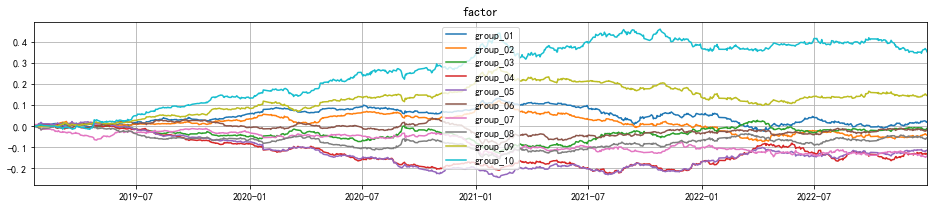

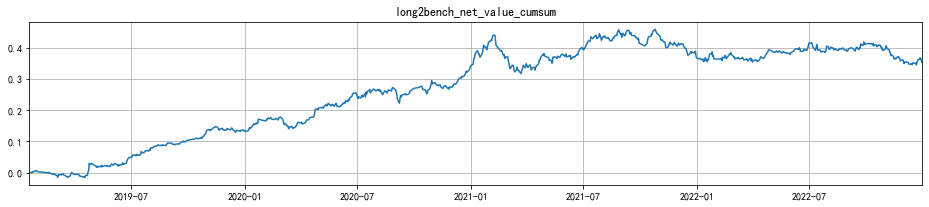

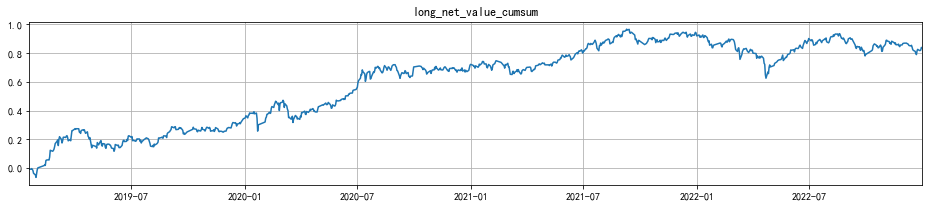

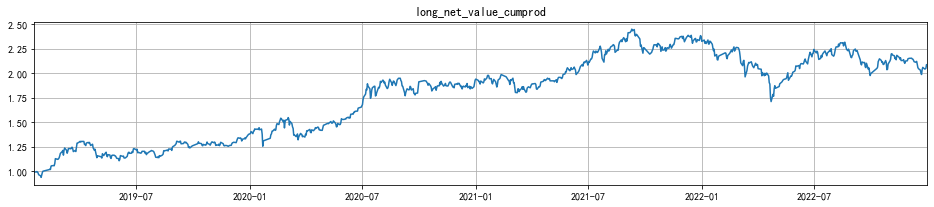

In [149]:
%run Quant_useful_packages.ipynb
C = SingleFactorAnalysis('000985.SH', '20190118', '20221231', 'factor_fill_1', 'pct_close_next_close', long_low=0, dt_index='240m', n_group=10, neu_style=None, calc_crowd=False)
result_df = C.run_code(nextpct_shift=1)
result_df

<AxesSubplot:>

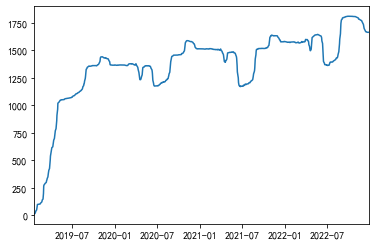

In [150]:
pd.notnull(C.factor_df).sum(axis=1).plot()